In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy.spatial import distance_matrix
from scipy import interpolate
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

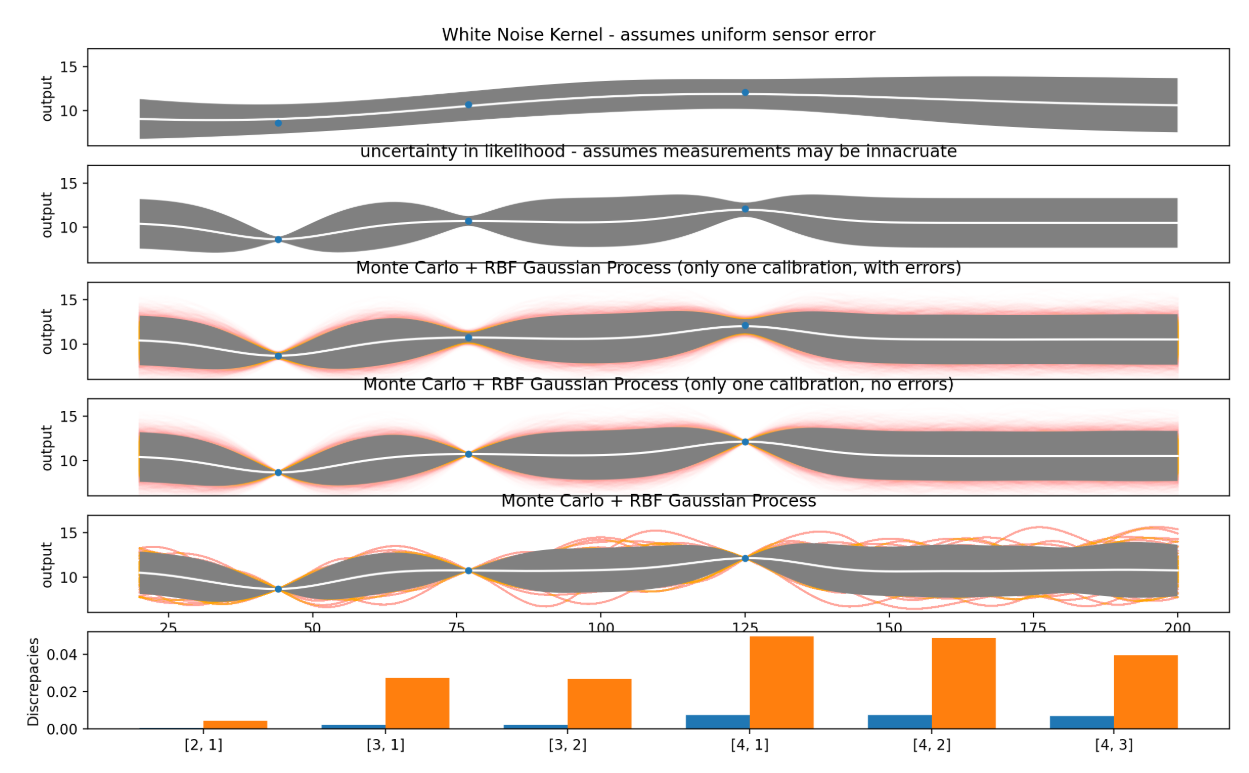

In [2]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']


# First dataset 
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test = train_test_split(X1,dm1.reshape(-1, 1),em1.reshape(-1,1),train_size=0.8,random_state=1)

# Second dataset
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2.reshape(-1,1), train_size=0.8, random_state=3)

# Third dataset
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3.reshape(-1,1), train_size=0.8, random_state=5)

# Fourth dataset
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4.reshape(-1,1), train_size=0.8, random_state=7)

X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
#E_train = np.concatenate((E1_train.reshape(-1,1),E2_train.reshape(-1,1),E3_train.reshape(-1,1),E4_train.reshape(-1,1)))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))

In [15]:
print(D_train.shape)
print(E_train.shape)

(800, 1)
(800, 1)


In [7]:
#Define the Gaussian Process kernel
#bounds_l = ((.08, 10), (1e-2, 10.0), (1e-2, 10.0), (1e-2, 10.0))  
#bounds_l = ((1e-4,10),(1e-4,10),(1e-4,10),(1e-4,10))
bounds_l = ((1e-100,1e20),(1e-100,1e20),(1e-100,1e20),(1e-100,1e20))
guess_l = (0.2,0.2,0.2,0.2)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)

#### Before Bed going to run 500 samples with 50 samples inside each

n_samples = 20  # Number of Monte Carlo samples
n_gp_samples = 100  # Number of function samples per GP

#C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * \
kernel = RBF(length_scale=guess_l, length_scale_bounds=bounds_l)



posterior_history = []  
for sample in tqdm(range(n_samples), desc="Monte Carlo Sampling Progress"):

    ####  This follows the logic since we are saying the error is normally distributed with error 0 and std E_train. There for the error bars which represent 1 standard deviation 
    ###### had this as np.random.normal(0, E_train) for ages should be E_train**2 I think
    sampled_D = D_train + np.random.normal(0, E_train)

    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer = 15)
    gpr.fit(X_train, sampled_D)

    posterior_sample = gpr.sample_y(X1, n_gp_samples)
    #print(posterior_sample.shape)# Expected shape: (250, 10)
    posterior_history.append(posterior_sample)  # Append directly

# Convert to NumPy array for final processing
posterior_history = np.array(posterior_history)  # Expected shape: (n_samples, 250, 10)

# print(posterior_history.shape) 

Monte Carlo Sampling Progress: 100%|██████████| 20/20 [01:20<00:00,  4.05s/it]


In [10]:
posterior_history = np.array(posterior_history)
print(posterior_history.shape)
final_mean = np.mean(posterior_history,axis=(0,2))
final_std = np.std(posterior_history,axis=(0,2))
final_mean.shape

(20, 250, 100)


(250,)

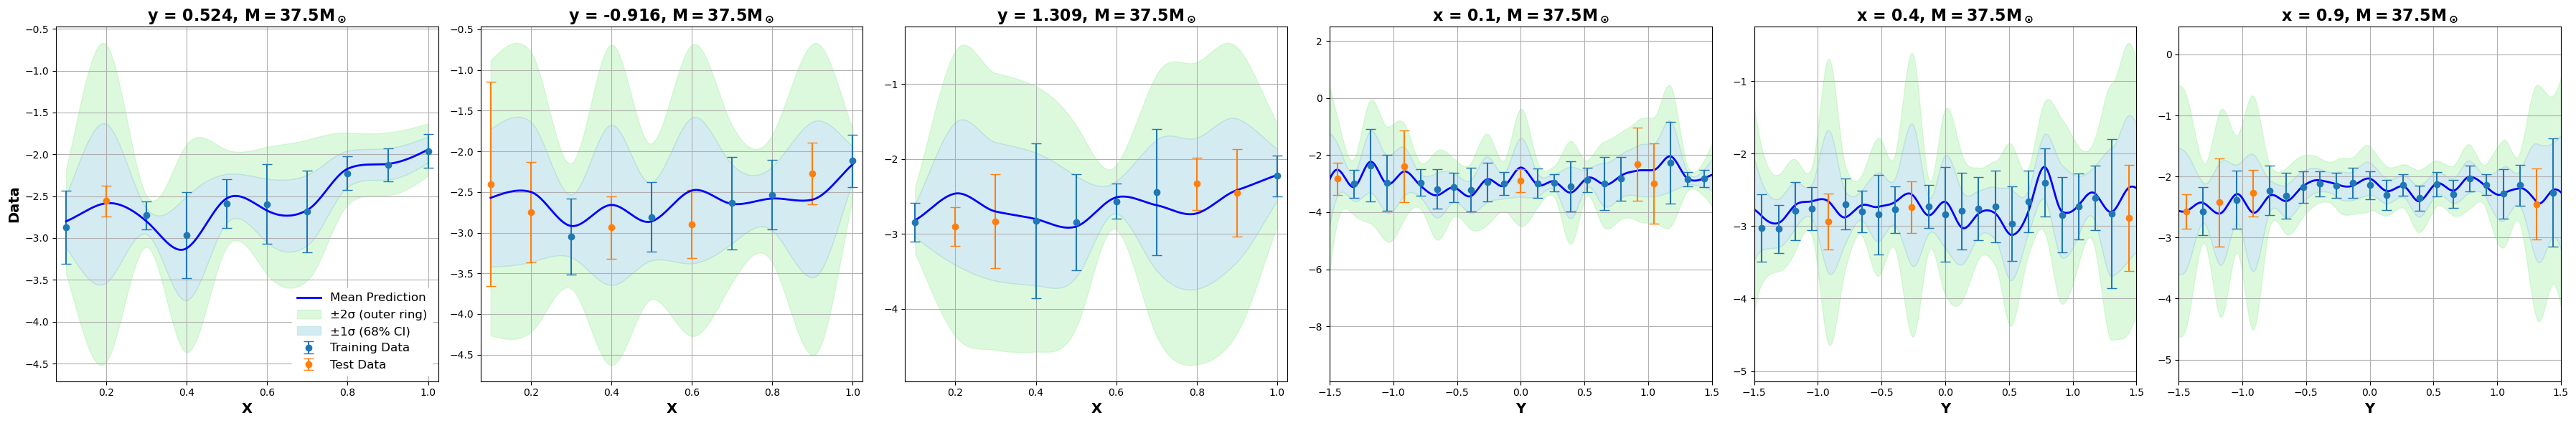

In [11]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
xpoints = np.linspace(0, 1, 1000)
ypoints = [0.5235987755982988,-0.9162978572970231,1.3089969389957472]
ypoints2 = np.linspace(-1.5707963267948966,1.5707963267948966,1000)
xpoints2 = [ 0.1,0.4,0.9]
titles = [
    f"y = {round(ypoints[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$"
]


fig, axes = plt.subplots(1, 6, figsize=(36, 6), sharey=False)
j = 0
for i, ax in enumerate(axes):
    if (i<=2):
        ypoint = ypoints[i]
        zgridlinear_mean = griddata((xm1, ym1), final_mean, (xpoints, ypoint), method="cubic")
        zgridlinear_std = griddata((xm1, ym1), final_std, (xpoints, ypoint), method="cubic")
        indices1 = np.isclose(y1train,ypoints[i])
        indices2 = np.isclose(y1test,ypoints[i])
        ax.errorbar(x1train[indices1].ravel(), D1_train[indices1].ravel(), yerr=E1_train[indices1].ravel(), fmt='o', capsize=5,label = 'Training Data')
        ax.errorbar(x1test[indices2].ravel(),D1_test[indices2].ravel(), yerr=E1_test[indices2].ravel(), fmt='o', capsize=5,label = 'Test Data')
        ax.plot(xpoints, zgridlinear_mean,label='Mean Prediction', color='blue', linewidth=2)
                # Fill the outer region (upper side): from m + σ to m + 2σ
        ax.fill_between(xpoints, 
                        zgridlinear_mean + zgridlinear_std, 
                        zgridlinear_mean + 2*zgridlinear_std, 
                        color='lightgreen', alpha=0.3, label='±2σ (outer ring)')

        # Fill the outer region (lower side): from m - 2σ to m - σ
        ax.fill_between(xpoints, 
                        zgridlinear_mean - 2*zgridlinear_std, 
                        zgridlinear_mean - zgridlinear_std, 
                        color='lightgreen', alpha=0.3)

        # Now fill the inner region (±1σ) on top
        ax.fill_between(xpoints, 
                        zgridlinear_mean - zgridlinear_std, 
                        zgridlinear_mean + zgridlinear_std, 
                        color='lightblue', alpha=0.5, label='±1σ (68% CI)')
        
        ax.set_xlim((0.075, 1.025))
        ax.set_xlabel('X', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
    else:
        xpoint = xpoints2[j]
        zgridlinear_mean = griddata((xm1, ym1), final_mean, (xpoint, ypoints2), method="cubic")
        zgridlinear_std = griddata((xm1, ym1), final_std, (xpoint, ypoints2), method="cubic")
        indices1 = np.isclose(x1train,xpoint)
        indices2 = np.isclose(x1test,xpoint)
        ax.plot(ypoints2, zgridlinear_mean, label='Mean Prediction', color='blue', linewidth=2)
        ax.errorbar(y1train[indices1].ravel(), D1_train[indices1].ravel(), yerr=E1_train[indices1].ravel(),fmt='o', capsize=5,label = 'Training Data')
        ax.errorbar(y1test[indices2].ravel(),D1_test[indices2].ravel(), yerr=E1_test[indices2].ravel(), fmt='o', capsize=5,label = 'Test Data')   
        # Fill the outer region (upper side): from m + σ to m + 2σ
        ax.fill_between(ypoints2, 
                        zgridlinear_mean + zgridlinear_std, 
                        zgridlinear_mean + 2*zgridlinear_std, 
                        color='lightgreen', alpha=0.3, label='±2σ (outer ring)')
        # Fill the outer region (lower side): from m - 2σ to m - σ
        ax.fill_between(ypoints2, 
                        zgridlinear_mean - 2*zgridlinear_std, 
                        zgridlinear_mean - zgridlinear_std, 
                        color='lightgreen', alpha=0.3)

        # Now fill the inner region (±1σ) on top
        ax.fill_between(ypoints2, 
                        zgridlinear_mean - zgridlinear_std, 
                        zgridlinear_mean + zgridlinear_std, 
                        color='lightblue', alpha=0.5, label='±1σ (68% CI)')
    
        ax.set_xlim((-1.5, 1.5))
        ax.set_xlabel('Y', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
        j+=1
        
axes[0].set_ylabel('Data', fontsize=14, weight='bold')

legend = axes[0].legend(fontsize=12,loc='lower right',frameon=True)
legend.get_frame().set_facecolor('white')  # Set the background color to grey
legend.get_frame().set_edgecolor('white')  # Optional: Add a black edge to the frame
legend.get_frame().set_alpha(1)  # Optional: Set opacity (1 = solid)
plt.tight_layout()
plt.show()